# Image Pre-processing 


In [1]:
""" All the imports needed by the main file """
import cv2 as cv
import matplotlib.pyplot as plt 
import numpy as np
import os
from utils import *
from preprocessing import *

## Resizing of Images 

Images in our dataset are large and will take time to be processed, an efficient way to solve this can be resizing the image to a smaller dimension. This will help us by: 
1. Easier to process
2. Orignal features will be kept intact with a smaller size


In [2]:
# Only run if you need to change the orignal size of the image.
files = get_all_files("./dataset")
for file in files:
    img = cv.imread(file)
    fileName = file.split("/")[-1].replace("JPG", "jpg")
    updated = cv.resize(img, (1200, 1200))
    if not os.path.isdir("./resized_dataset"):
        os.mkdir("./resized_dataset")
    cv.imwrite(f"./resized_dataset/{fileName}", updated)

In [3]:
""" Global variables/constants """
if os.path.isdir("./resized_dataset"):
    files = get_all_files("./resized_dataset")
else:
    files = get_all_files("./dataset")

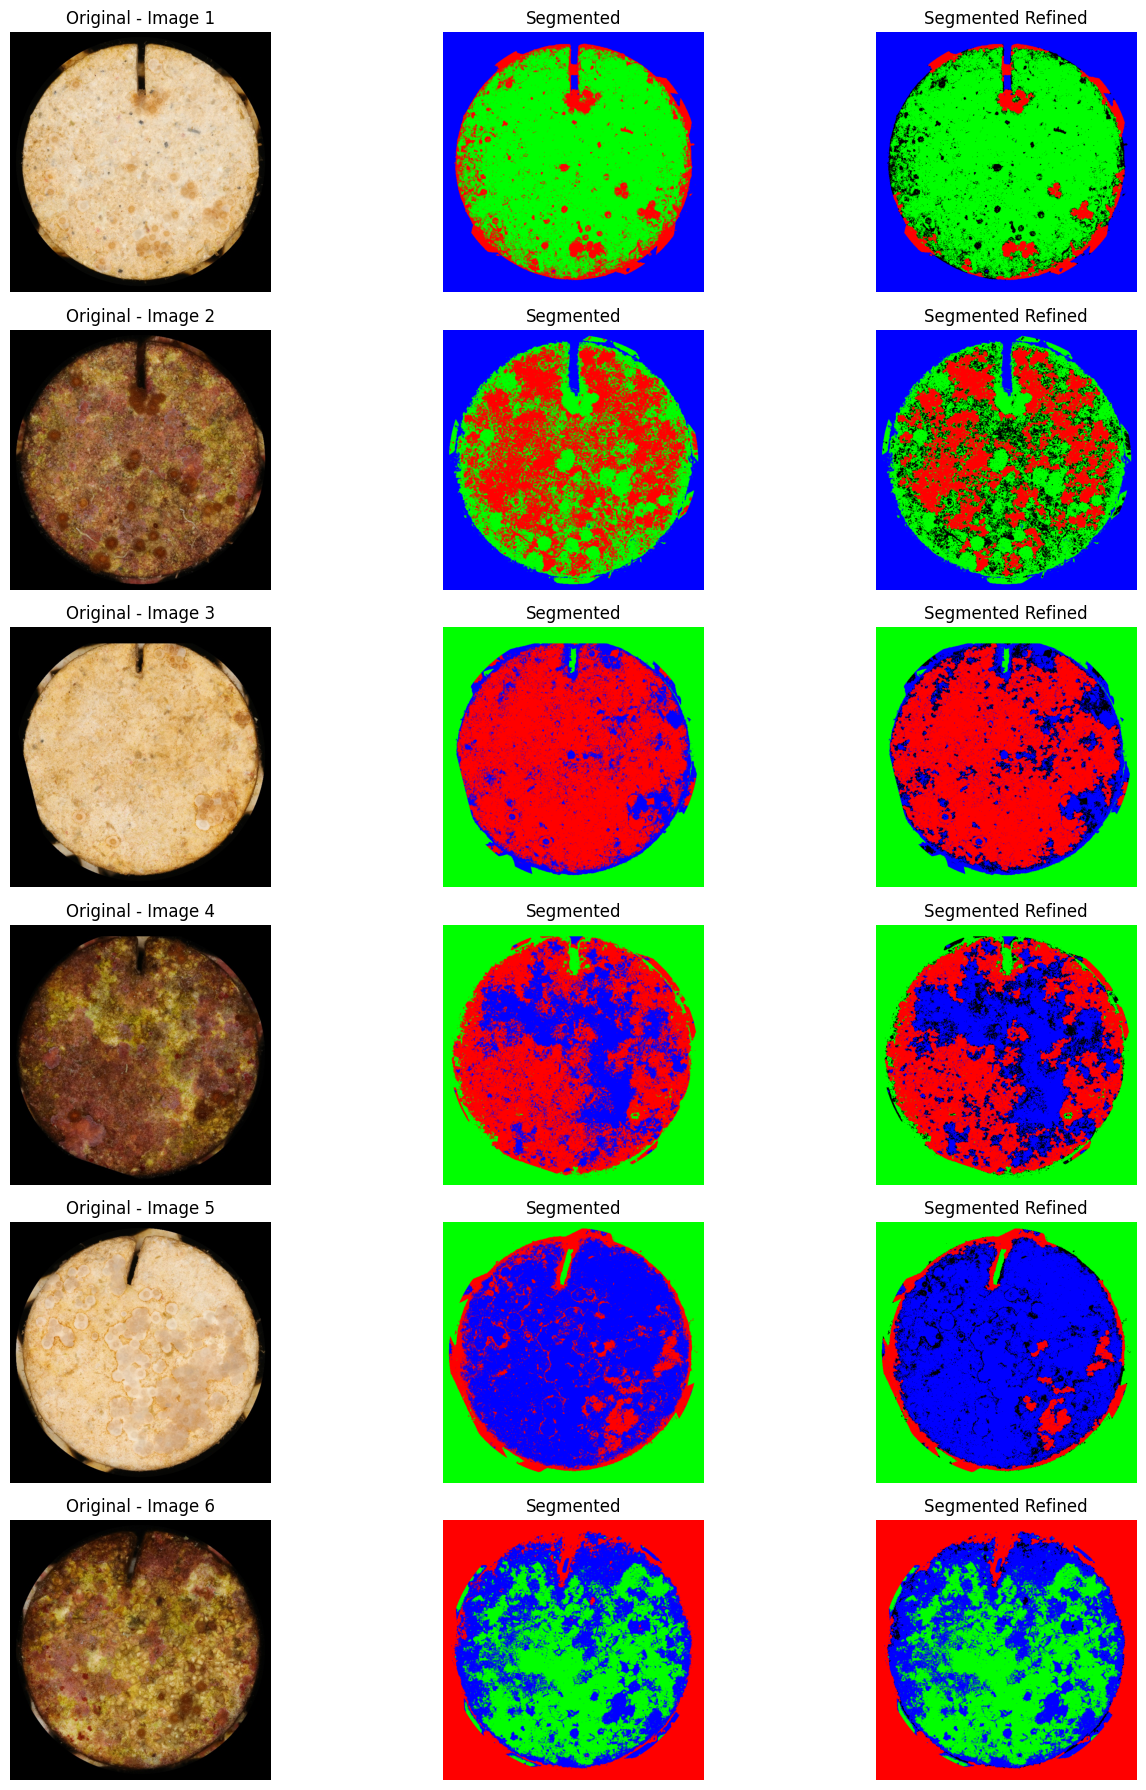

In [4]:
fig = plt.figure(figsize=(18, 18))
for idx, file in enumerate(files[:6]):
    image = cv.imread(file)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Convert to LAB color space
    image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)

    # Reshape the image to a 2D array of pixels
    pixel_values = image_lab.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Perform k-means clustering
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 3  # Number of clusters
    _, labels, _ = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # Map cluster labels to colors
    segmented_colors = np.zeros_like(pixel_values)
    colors = np.array([[255, 0, 0],  # Red
                    [0, 255, 0],  # Green
                    [0, 0, 255]])  # Blue
    for i in range(k):
        segmented_colors[labels.flatten() == i] = colors[i]

    segmented_image = segmented_colors.reshape(image.shape)

    # Refine the red region (cluster 0 here as an example)
    red_mask = (labels.flatten() == 0).reshape(image.shape[:2])

    # Reduce noise in the red mask
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))  # Adjust size as needed

    # Step 1: Apply morphological opening to remove noise
    red_mask_opened = cv.morphologyEx(red_mask.astype(np.uint8), cv.MORPH_OPEN, kernel)

    # Step 2: Apply morphological closing to fill small holes
    red_mask_refined = cv.morphologyEx(red_mask_opened, cv.MORPH_CLOSE, kernel)

    # Step 3: Filter out small components using connected component analysis
    num_labels, labels_im = cv.connectedComponents(red_mask_refined)
    min_component_size = 500  # Adjust based on your needs
    for label in range(1, num_labels):  # Ignore label 0 (background)
        if np.sum(labels_im == label) < min_component_size:
            red_mask_refined[labels_im == label] = 0

    # Update the red region in the segmented image
    segmented_colors_refined = segmented_colors.copy()
    segmented_colors_refined[red_mask.flatten().astype(bool)] = [255, 0, 0]  # Keep red
    segmented_colors_refined[~red_mask_refined.flatten().astype(bool) & (labels.flatten() == 0)] = [0, 0, 0]  # Remove excess red

    # Combine refined red, green, and blue
    segmented_image_refined = segmented_colors_refined.reshape(image.shape)

    plt.subplot(6, 4, idx * 4 + 1)
    plt.title(f"Original - Image {idx+1}")
    plt.imshow(image_rgb.astype('uint8'))
    plt.axis('off')

    plt.subplot(6, 4, idx * 4 + 2)
    plt.title("Segmented")
    plt.imshow(segmented_image.astype('uint8'))
    plt.axis('off')

    plt.subplot(6, 4, idx * 4 + 3)
    plt.title("Segmented Refined")
    plt.imshow(segmented_image_refined.astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.savefig("./output/segmentation_colored.png")
plt.show()